In [2]:
from pymol import cmd
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calculate_rmsd_LSU_SSU(reference_structure, target_structure):
    cmd.load(reference_structure, 'reference')
    cmd.load(target_structure, 'target')

    cmd.select('reference_LSU_SSU', 'reference and (chain A or chain M)')
    cmd.select('target_LSU_SSU', 'target and (chain A or chain M)')


    align_result = cmd.align("target_LSU_SSU", "reference_LSU_SSU", cycles=0, transform=0)
    rmsd = align_result[0]

    cmd.delete('reference')
    cmd.delete('target')
    cmd.delete('reference_LSU_SSU')
    cmd.delete('target_LSU_SSU')

    return rmsd

Create matrix with RMSD values between structures

In [3]:
cmd.reinitialize()

structures = [f for f in os.listdir('data/structures') if f.endswith('.pdb')]
num_structures = len(structures)

rmsd_matrix = np.zeros((num_structures, num_structures))

structure_ids = [s.split('_relaxed')[0] for s in structures]

# Calculate RMSD for each pair of structures
for i in range(num_structures):
    for j in range(i + 1, num_structures):
        structure1 = os.path.join('data/structures', structures[i])
        structure2 = os.path.join('data/structures', structures[j])
        rmsd = calculate_rmsd_LSU_SSU(structure1, structure2)
        rmsd_matrix[i, j] = rmsd
        rmsd_matrix[j, i] = rmsd

In [4]:
df = pd.DataFrame(rmsd_matrix, index=structure_ids, columns=structure_ids)

df.to_csv('outputs/rmsd_LSU_SSU_all_atoms_matrix.csv')

Calculate median RMSD

In [14]:
# extract upper triangular part of the matrix
upper_triangle = np.triu(rmsd_matrix)

# exclude zeros to calculate median RMSD
median_rmsd = np.median(upper_triangle[upper_triangle > 0])

print(median_rmsd)


2.6957919597625732


Plot

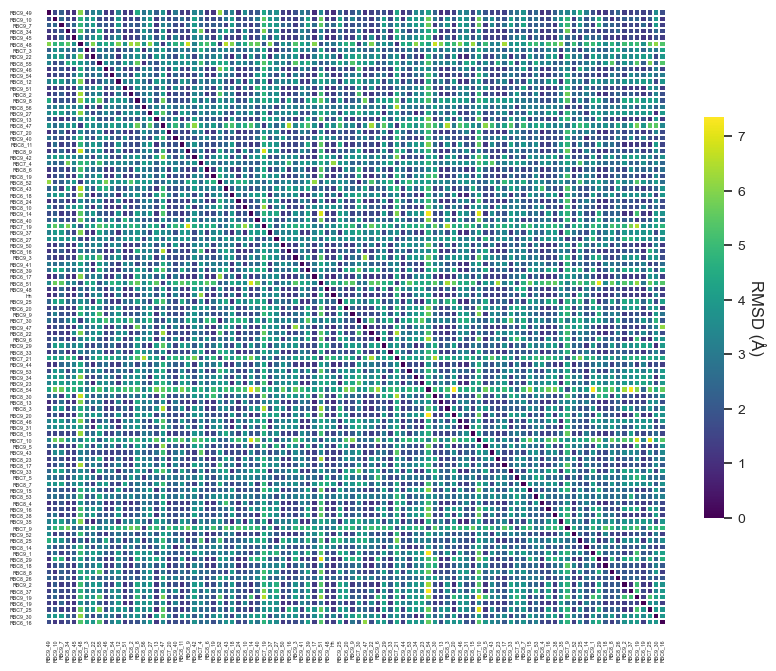

In [4]:
rmsd_matrix_df = pd.read_csv('outputs/rmsd_LSU_SSU_all_atoms_matrix.csv', index_col=0)

sns.set(font_scale=0.34)
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(rmsd_matrix_df, cmap='viridis', annot=False, fmt=".2f", linewidths=.1, cbar_kws={'shrink': 0.65})

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10.0)
cbar.set_label('RMSD (Å)', rotation=270, labelpad=15, fontsize=12)

plt.savefig('plots/rmsd_LSU_SSU_all_atoms_matrix.svg', dpi=300)
plt.show()
